In [35]:
import sys
sys.path.append('../src')
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from ODE_solver import ode_sistema
import ODE_solver
import importlib
from scipy.interpolate import interp1d

def full_potencial(y, lam, v, xi, Mp): 
    return (Mp**4*lam/4)*((1/xi)*np.exp(2*y) - v**2)**2/(1 + np.exp(2*y))**2

def h_potencial(h, lam, v):
    return (lam/4)*(h**2 - v**2)**2/(1+ 10*h**2)**2

def large_potencial(y):
    return 10*(1 + np.exp(-2*y))**(-2)

def potencial_aproximado(y):
    return 0.5*(1 -2*np.exp(-2*y))

In [36]:

importlib.reload(ODE_solver)

<module 'ODE_solver' from 'c:\\Users\\diego\\OneDrive\\Documentos\\Universidad\\Cosmologia\\Efolds\\ODE_solver.py'>

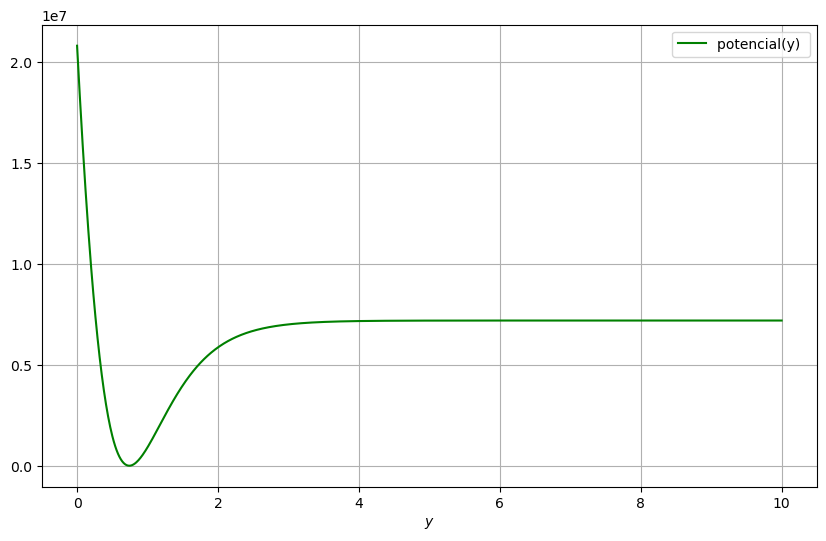

In [37]:
esc = 1
lam = 1.3e-1
v = 2.098e-17
xi = 1e34
Mp = 1.22e19 # GeV
y0, v0 = 5, 0
tc = xi/(Mp*np.sqrt(lam))

y_span = np.linspace(0, 10, 1000)
plt.figure(figsize=(10, 6))
plt.plot(y_span, full_potencial(y_span, lam, v, xi, Mp), 'g-', label="potencial(y) ")
plt.legend()
#plt.xlim(0,0.000000000000005)
#plt.ylim(0,1)
plt.xlabel(r"$y$")
plt.grid(True)
plt.show()

In [38]:

t_span = (0,12000)
sol = solve_ivp(ode_sistema, t_span, [y0, v0], method='BDF',  dense_output=True)  # Solución numérica

tau = np.linspace(t_span[0],t_span[1], t_span[1]*10)

y, vel = sol.sol(tau)[0], sol.sol(tau)[1]  # Guardamos la solución numérica para el campo y su derivada.
potencial = full_potencial(y, lam, v, xi, Mp)

In [39]:
damping = (3*xi*vel/esc)*np.sqrt( (1/12)* ( (np.exp(2*y)/xi - v**2)**2 / (1 + np.exp(2*y))**2)  + (vel**2)/(esc**2*xi**2))
forcing = (1/6)*( np.exp(2*y)*(np.exp(2*y) - xi*v**2)*(1+xi*v**2) )/(1 + np.exp(2*y))**3
acc =esc**2*(-damping - forcing)

In [40]:
# Guardar Datos

np.savez('../data/solution_dense.npz',
         tau=tau,
         y=y,
         vel=vel,
         # Parameters
         lam=lam,
         v=v,
         xi=xi,
         Mp=Mp,
         y0=y0,
         v0=v0,
         t_span=t_span,
         # Store the original solution points too
         y_original=sol.sol(tau)[0],
         vel_original=sol.sol(tau)[1])



# Leer datos

data = np.load('../data/solution_dense.npz')

tau = data['tau']
y = data['y']
vel = data['vel']


y_interp = interp1d(tau, y, kind='cubic')
vel_interp = interp1d(tau, vel, kind='cubic')


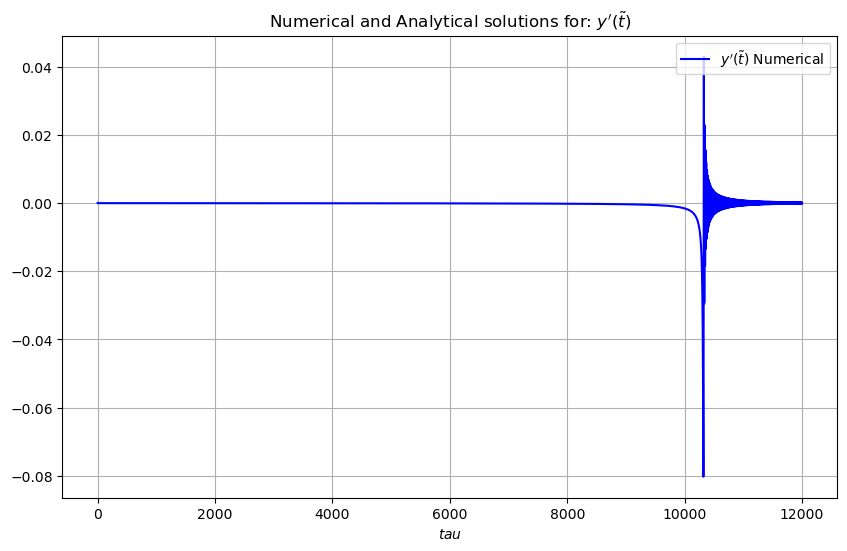

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(tau,vel_interp(tau), 'b-', label=r"$y^\prime(\tilde{t})$ Numerical")
plt.legend(loc="upper right")
#plt.xlim(0,200)
plt.xlabel(r"$tau$")
plt.grid(True)
plt.title(r'Numerical and Analytical solutions for: $y^\prime(\tilde{t})$')
plt.show()

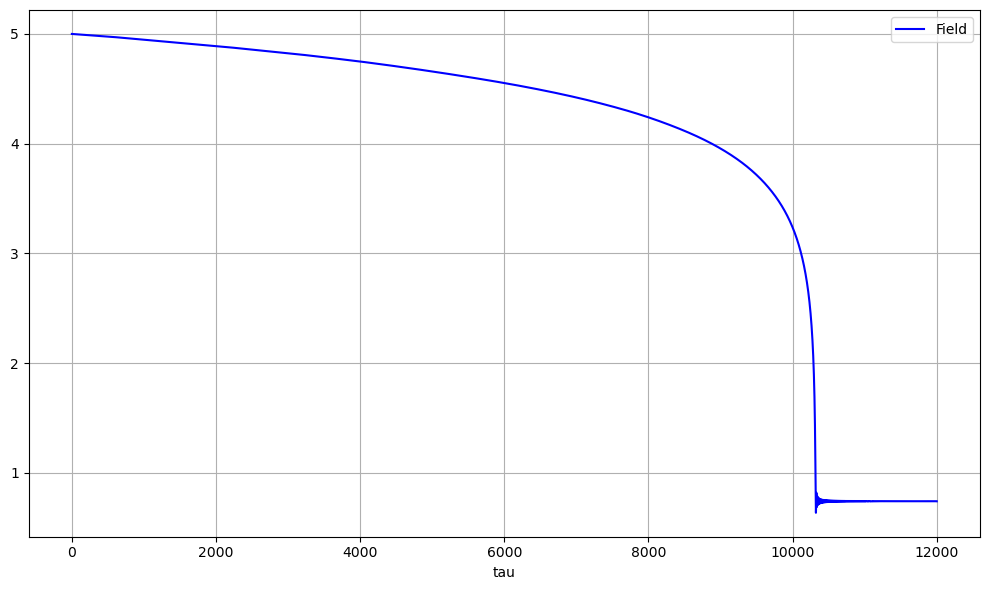

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(tau, y_interp(tau), 'b-', label=r"Field")
#plt.xlim(0,5000)
#plt.ylim(-1, 4.5)  
plt.xlabel(r"tau")
plt.ylabel('')
#plt.title(r'Numerical solutions for: $y(\tilde{t})$, $y^\prime(\tilde{t})$, and $y^{\prime\prime}(\tilde{t})$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Graphs as function of y

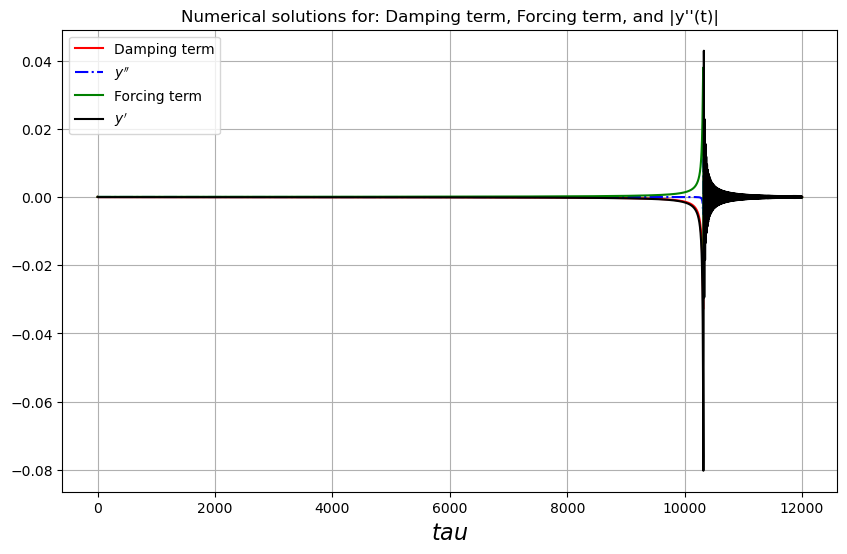

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(tau, (damping), 'r', label="Damping term")
plt.plot(tau, (acc), 'b-.', label=r"$y^{\prime\prime}$")
plt.plot(tau, (forcing), 'g', label="Forcing term")
plt.plot(tau, (vel), 'k-', label=r"$y^\prime$")
plt.title('Numerical solutions for: Damping term, Forcing term, and |y\'\'(t)|')
#plt.xlim(0,5)
#plt.ylim(-0.002, 0.002)  
plt.legend()
plt.xlabel(r"$tau$", fontsize=16)
plt.grid()
plt.show()

### Start and ending of inflation 

Para el inicio de inflación necesitamos que la densidad de energía potencial sea mucho mayor a la cinética.

Para el fin de inflación y comienzo de reheating necesitamos que la densidad de energía cinética sea comparable a la potencial o en otros términos, el parámetro de slow roll $\epsilon = 1$.


In [44]:
H = np.sqrt(lam)*Mp*np.sqrt((1/xi**2)*vel**2 + (((1/xi)*np.exp(2*y) - v**2)**2/(1 + np.exp(2*y))**2)/(12)) # Unidades de 1/t= m


dH_dt = np.sqrt(lam)*Mp*np.gradient(H, tau)/xi # Hdot = dH/dt where t is cosmic time. Can be confusing as im using t as adimensional time also.

epsilon = -dH_dt/H**2 # Parámeteo de slow roll
epsilon_v = 0.5*(forcing/potencial)**2

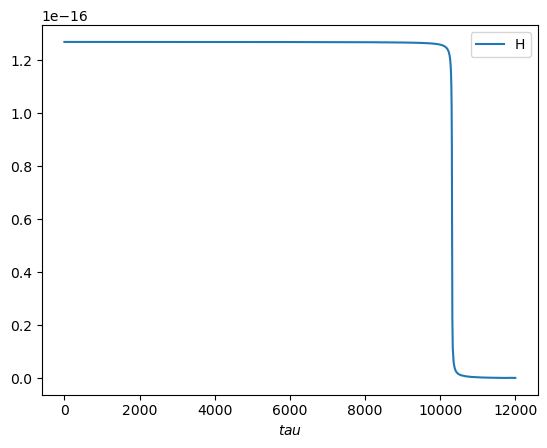

In [45]:
plt.plot(tau, H, label='H')
#plt.yscale('log')
plt.xlabel(r'$tau$')
#plt.xlim(0, 3.5)
plt.legend(loc="upper right")
plt.show()

In [46]:
# Criterio para comienzo de inflación
start_condition = epsilon < 1 # Condiciones para slow roll
#start_condition_v = epsilon_v < 1
t0 = tau[start_condition][0]  
t0


end_condition =  epsilon > 1
end_condition_v = epsilon_v > 1


In [47]:

t_end = tau[end_condition][0]
#t_end_v = tau[end_condition_v][0]

t0, t_end

(np.float64(0.0), np.float64(10317.085975716464))

In [48]:
y_start = y[start_condition][0]
y_end = y[end_condition][0]
#y_end_v = y[end_condition_v][0]
y_start, y_end

(np.float64(5.0), np.float64(1.0153113884055749))

In [49]:
plt.rcParams['agg.path.chunksize'] = 100

In [50]:
kinetic = 3*lam*Mp**4*vel**2/xi**2

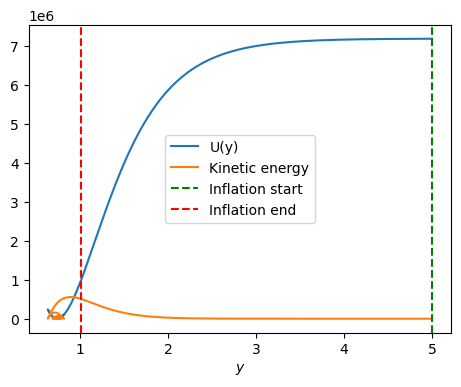

In [51]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(y, potencial, label='U(y)')
plt.plot(y, kinetic , label='Kinetic energy')
plt.axvline(y0, color='g', linestyle='--', label='Inflation start')
plt.axvline(y_end, color='r', linestyle='--', label='Inflation end')
#plt.ylim(0,2.1)
#plt.xlim(0,5)
plt.xlabel(r"$y$")
plt.legend()



In [52]:
def calcular_efolds(t_star_candidato):
    mask = (tau >= t_star_candidato) & (tau <= t_end)  
    H_dominio = H[mask]
    tau_segment = tau[mask]
    N_int = np.trapezoid(H_dominio, tau_segment)
    return tc * N_int

target_N = 50

# range de busqueda
t_low = t0  
t_high = t_end  

tolerancia = 1e-3
max_iter = 50

for i in range(max_iter):
    t_mid = (t_low + t_high) / 2
    current_N = calcular_efolds(t_mid)
    
    if abs(current_N - target_N) < tolerancia:
        t_star = t_mid 
        break
    elif current_N < target_N:
        t_high = t_mid
    else:
        t_low = t_mid
        
    if i == max_iter - 1:
        t_star = t_mid
        print(f"Máximo de iteraciones alcanzadas. Mejor t* = {t_star}")

mask_verify = (tau >= t_star) & (tau <= t_end)
N_verify = tc * np.trapezoid(H[mask_verify], tau[mask_verify])
print(f"N* desde t* hasta t_end = {N_verify}")



Máximo de iteraciones alcanzadas. Mejor t* = 10132.984441537004
N* desde t* hasta t_end = 50.00118627457506


In [53]:
t_star

np.float64(10132.984441537004)

In [54]:
mask = (tau >= t_star) & (tau <= t_end)
#mask_v = (tau >= t_star) & (tau <= t_end_v)
tau_inf = tau[mask]
#tau_inf_v = tau[mask_v]
H_inf = H[mask]
#H_inf_v = H[mask_v]

N_int = np.trapezoid(H_inf, tau_inf)
#N_int_v = np.trapezoid(H_inf_v, tau_inf_v)
N = tc*N_int
#N_v = tc*N_int_v
# Print Number of efolds
print(f"Numero de efolds N: {N} (desde tau = {t_star} a tau = {t_end})")
#print(f"Numero de efolds N: {N} (desde y0 = {y0} a y* = {y_star})")
#print(f"Numero de efolds N_v: {N_v} (desde tau = {t_star} a tau = {t_end_v})")

Numero de efolds N: 50.00118627457506 (desde tau = 10132.984441537004 a tau = 10317.085975716464)


In [55]:
dot_epsilon = np.gradient(epsilon, tau)/tc
eta1 = dot_epsilon/(2*H*epsilon) - epsilon

In [56]:
#d2H_dt2 = np.gradient(dH_dt, tau)/tc

In [57]:
from scipy import signal

# Smooth H first with a Savitzky-Golay filter
window_length = 100  # odd number, adjust based on your data size
polyorder = 3       # polynomial order

H_smooth = signal.savgol_filter(H, window_length, polyorder)

# Then compute derivatives on smoothed data
dH_dt = np.gradient(H_smooth, tau)/tc
d2H_dt2 = np.gradient(dH_dt, tau)/tc


eta1 = d2H_dt2/(2*H*dH_dt)

In [58]:
idx_star = np.argmin(np.abs(tau - t_star))
epsilon_star = epsilon[idx_star]
eta_star = eta1[idx_star]
H_star = H[idx_star]
epsilon_v_star = epsilon_v[idx_star]
y_star = y[idx_star]
print(f"Parámetros al cruzar el horizonte: ε* = {epsilon_star}, η* = {eta_star}")
print(f"Observables: ns = {1 - 4*epsilon_star + 2*eta_star}, r = {16*epsilon_star}")
#print(f"Observables: ns_v = {1 - 6*epsilon_v_star + 2*eta_star}, r_v = {16*epsilon_v_star} ")

Parámetros al cruzar el horizonte: ε* = 0.00028167701227588916, η* = 0.01902079275912923
Observables: ns = 1.036914877469155, r = 0.004506832196414227


In [59]:
idx_star

np.int64(101329)

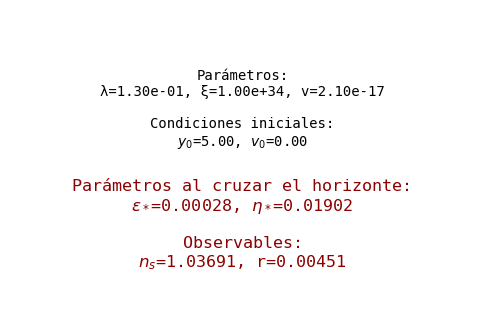

Figura guardada como: figuras/(N=50.0)params_lambda1.3e-01_xi1.0e+34_v2.1e-17_y05.0_v00.0.png


In [60]:
ns = 1 - 4*epsilon_star + 2*eta_star
r = 16*epsilon_star

fig, ax = plt.subplots(figsize=(6,4))
ax.axis('off')

text_params = (
    f"Parámetros:\n"
    f"λ={lam:.2e}, ξ={xi:.2e}, v={v:.2e}\n\n"
    f"Condiciones iniciales:\n"
    f"$y_0$={y0:.2f}, $v_0$={v0:.2f}\n"
)

text_obs = (
    f"Parámetros al cruzar el horizonte:\n"
    f"$ε_*$={epsilon_star:.5f}, $η_*$={eta_star:.5f}\n\n"
    f"Observables:\n"
    f"$n_s$={ns:.5f}, r={r:.5f}"
)

ax.text(0.5, 0.65, text_params, ha='center', va='center', fontsize=10, family='monospace')

ax.text(0.5, 0.3, text_obs, ha='center', va='center', fontsize=12, family='monospace', color='darkred')

filename = f"figuras/(N={N:.1f})params_lambda{lam:.1e}_xi{xi:.1e}_v{v:.1e}_y0{y0:.1f}_v0{v0:.1f}.png"

plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()

print(f"Figura guardada como: {filename}")


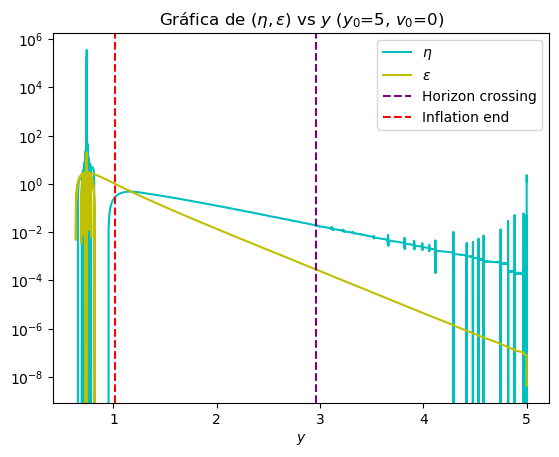

In [61]:
# plot eta vs y 
plt.title(r'Gráfica de ($\eta,\epsilon$) vs $y$ ($y_0$={}, $v_0$={})'.format(y0, v0))

#plt.plot(y, eta2, label=r'$\eta(H)$')
plt.plot(y, eta1, color='c', label=r'$\eta$')
plt.plot(y, epsilon, color='y', label=r'$\epsilon$')
plt.axvline(y_star, color='purple', linestyle='--', label='Horizon crossing')
plt.axvline(y_end, color='r', linestyle='--', label='Inflation end')
plt.legend()
plt.yscale('log')
plt.xlabel(r"$y$")
plt.savefig(f'../images/figuras/(N={N:.1f})eta-epsilon vs y (y0={y0}, v0={v0}).png')
plt.show()

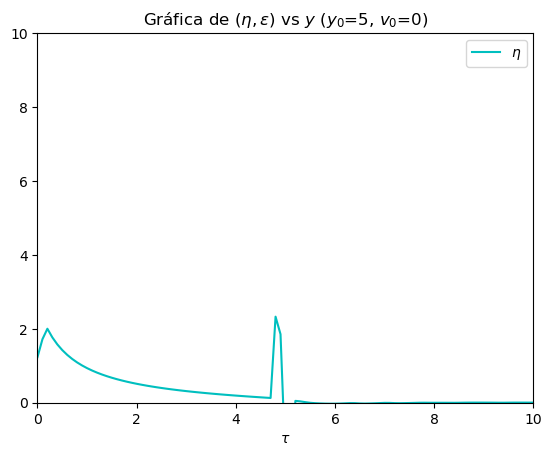

In [62]:
# plot eta vs y 
plt.title(r'Gráfica de ($\eta,\epsilon$) vs $y$ ($y_0$={}, $v_0$={})'.format(y0, v0))

#plt.plot(y, eta2, label=r'$\eta(H)$')
plt.plot(tau, eta1, color='c', label=r'$\eta$')
#plt.plot(tau, epsilon, color='y', label=r'$\epsilon$')
#plt.axvline(y_star, color='purple', linestyle='--', label='Horizon crossing')
#plt.axvline(y_end, color='r', linestyle='--', label='Inflation end')
plt.legend()
plt.xlim(0,10)
plt.ylim(0,10)
#plt.yscale('log')
plt.xlabel(r"$\tau$")
#plt.savefig(f'../images/figuras/(N={N:.1f})eta-epsilon vs tau (y0={y0}, v0={v0}).png')
plt.show()


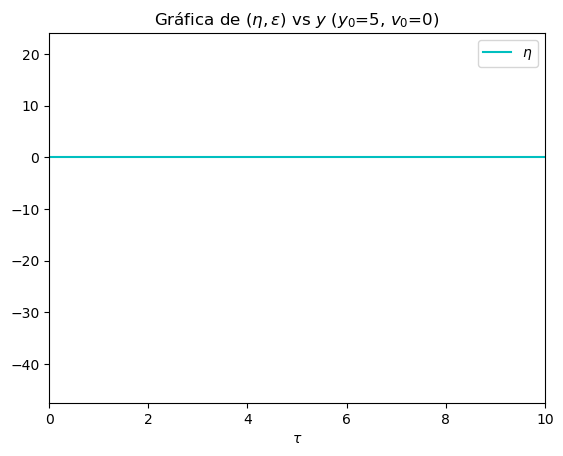

In [63]:
# plot eta vs y 
plt.title(r'Gráfica de ($\eta,\epsilon$) vs $y$ ($y_0$={}, $v_0$={})'.format(y0, v0))

#plt.plot(y, eta2, label=r'$\eta(H)$')
plt.plot(tau, epsilon, color='c', label=r'$\eta$')
#plt.plot(tau, epsilon, color='y', label=r'$\epsilon$')
#plt.axvline(y_star, color='purple', linestyle='--', label='Horizon crossing')
#plt.axvline(y_end, color='r', linestyle='--', label='Inflation end')
plt.legend()
plt.xlim(0,10)
#plt.ylim(0,10)
#plt.yscale('log')
plt.xlabel(r"$\tau$")
#plt.savefig(f'../images/figuras/(N={N:.1f})eta-epsilon vs tau (y0={y0}, v0={v0}).png')
plt.show()